In [16]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import umap.umap_ as umap
import torch
import pickle
import hashlib
import numpy as np
import pandas as pd

plt.rcParams["font.family"] = "Dejavu Sans"
plt.rcParams["figure.figsize"] = (12, 8)

class AnatomyEmbeddingComparator :
    def __init__(self) :
        self.models = {}
        self.tokenizers = {}
        self.documents = {}
        self.embeddings = {}
        self.labels = []
        self.cache_dir = "./cache/embeddings"
        os.makedirs(self.cache_dir, exist_ok=True)

        self.anatomy_files = [
            "1_Embryology.md",
            "2_Osteology.md", 
            "3_Syndesmology.md",
            "4_Myology.md",
            "5_Angiology.md",
            "6_The_Arteries.md",
            "7_The_Veins.md",
            "8_The_Lymphatic_System.md",
            "9_Neurology.md",
            "10_The_Organs_of_the_Senses_and_the_Common_Integument.md",
            "11_Splanchnology.md",
            "12_Surface_Anatomy_and_Surface_Markings.md"
        ]

        self.topic_labels = [
            "발생학", "골학", "인대학", "근육학", "혈관학",
            "동맥", "정맥", "림프계", "신경학", "감각기관",
            "내장학", "표면해부학"
        ]

    def _get_text_hash(self, texts):
        combined_text = "".join(texts)
        return hashlib.md5(combined_text.encode('utf-8')).hexdigest()
    
    def _get_cache_filename(self, model_name, text_hash):
        return os.path.join(self.cache_dir, f"{model_name}_{text_hash}.pkl")
    
    def save_embeddings_cache(self, model_name, texts, embeddings):
        text_hash = self._get_text_hash(texts)
        cache_file = self._get_cache_filename(model_name, text_hash)
        
        cache_data = {
            'embeddings': embeddings,
            'texts_hash': text_hash,
            'model_name': model_name,
            'num_texts': len(texts)
        }
        
        try:
            with open(cache_file, 'wb') as f:
                pickle.dump(cache_data, f)
            print(f"{model_name} 임베딩 캐시 저장 완료: {cache_file}")
        except Exception as e:
            print(f"{model_name} 임베딩 캐시 저장 실패: {e}")
    
    def load_embeddings_cache(self, model_name, texts):
        text_hash = self._get_text_hash(texts)
        cache_file = self._get_cache_filename(model_name, text_hash)
        
        if not os.path.exists(cache_file):
            return None
        
        try:
            with open(cache_file, 'rb') as f:
                cache_data = pickle.load(f)
            
            # 캐시 유효성 검증
            if (cache_data['texts_hash'] == text_hash and 
                cache_data['model_name'] == model_name and
                cache_data['num_texts'] == len(texts)):
                print(f"{model_name} 캐시된 임베딩 로드 완료")
                return cache_data['embeddings']
        except Exception as e:
            print(f"{model_name} 캐시 로드 실패: {e}")
        
        return None
    
    def clear_cache(self):
        try:
            for filename in os.listdir(self.cache_dir):
                if filename.endswith('.pkl'):
                    os.remove(os.path.join(self.cache_dir, filename))
            print("임베딩 캐시 정리 완료")
        except Exception as e:
            print(f"캐시 정리 실패: {e}")

    def load_models(self) :
        model_paths = {
            "ClinicalBERT" : "./model/embedding/ClinicalBert",
            "MedEmbed" : "./model/embedding/MedEmbed",
            "PubMedBERT" : "./model/embedding/pubmedbert",
            "BGE-M3" : "./model/embedding/bge-m3",
            "BiobertNLI" : "./model/embedding/BiobertNLI",
            "SPubMedBertMS" : "./model/embedding/SPubMedBertMS",
            "BioBertV1.1" : "./model/embedding/BioBertV1.1",
            "BioClinicalBert" : "./model/embedding/BioClinicalBert",
            "ScibertScivocabUncased" : "./model/embedding/ScibertScivocabUncased",
            "ScibertScivocabCased" : "./model/embedding/ScibertScivocabCased",
            "BioMedNLPPubMedBERT" : "./model/embedding/BioMedNLPPubMedBERT"
        }

        for name, path in model_paths.items() :
            try :
                if name == "SPubMedBertMS" or name == "BGE-M3" :
                    self.models[name] = SentenceTransformer(path)
                else :
                    self.tokenizers[name] = AutoTokenizer.from_pretrained(path)
                    self.models[name] = AutoModel.from_pretrained(path)
                print(f"{name} 모델 로드 완료")
            except Exception as e :
                print(f"{name} 모델 로드 실패 : {e}")

    def load_documents(self) :
        data_path = "./data/split_file/anatomy"

        for i, filename in enumerate(self.anatomy_files) :
            file_path = os.path.join(data_path, filename)
            try :
                with open(file_path, 'r', encoding="utf-8") as f :
                    content = f.read()
                    paragraphs = [p.strip() for p in content.split("\n\n") if p.strip()]
                    self.documents[self.topic_labels[i]] = paragraphs
                    self.labels.extend([i] * len(paragraphs))
                print(f"{filename} 로드 완료 : {len(paragraphs)}개 문단")
            except Exception as e :
                print(f"{filename} 로드 실패 : {e}")

    def get_embeddings(self, model_name, texts) :
        cached_embeddings = self.load_embeddings_cache(model_name, texts)
        if cached_embeddings is not None:
            return cached_embeddings
        
        if model_name == "BGE-M3" or model_name == "SPubMedBertMS" : 
            embeddings = self.models[model_name].encode(texts, convert_to_tensor=False)
        else :
            model = self.models[model_name]
            tokenizer = self.tokenizers[model_name]

            embeddings = []
            for text in texts :
                inputs = tokenizer(text, return_tensors="pt", truncation=True,
                                   padding=True, max_length=512)
                with torch.no_grad() :
                    outputs = model(**inputs)
                    embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
                    embeddings.append(embedding)
            
            embeddings = np.array(embeddings)
        self.save_embeddings_cache(model_name, texts, embeddings)

        return np.array(embeddings)

    def generate_all_embeddings(self) :
        all_texts = []
        for paragraphs in self.documents.values() :
            all_texts.extend(paragraphs)

        for model_name in self.models.keys() :
            embeddings = self.get_embeddings(model_name, all_texts)
            self.embeddings[model_name] = embeddings
            print(f"{model_name} 임베딩 생성 완료")

    def analyze_cosine_similarity(self) :
        num_models = len(self.embeddings)
        cols = 3
        rows = (num_models + cols - 1) // cols
        
        _, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))        
        if rows == 1:
            axes = [axes]
        axes = np.array(axes).flatten()

        for i, (model_name, embeddings) in enumerate(self.embeddings.items()) :
            cos_sim_matrix = cosine_similarity(embeddings)
            cos_sim_values = cos_sim_matrix[np.triu_indices_from(cos_sim_matrix, k=1)]

            axes[i].hist(cos_sim_values, bins=50, alpha=0.7, density=True)
            axes[i].set_title(f"{model_name} distribution of cosine sim")
            axes[i].set_xlabel("cosine sim")
            axes[i].set_ylabel("density")
            axes[i].grid(True, alpha=0.3)

            mean_sim = np.mean(cos_sim_values)
            std_sim = np.std(cos_sim_values)
            axes[i].axvline(mean_sim, color="red", linestyle="--", 
                            label=f"평균 : {mean_sim:.3f}+-{std_sim:.3f}")
            axes[i].legend()
        
        for i in range(num_models, len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()
        plt.savefig("cosine_similarity_distribution.png", dpi=300, bbox_inches="tight")
        plt.show()

    def visualize_embeddings(self) :
        num_models = len(self.embeddings)
        cols = min(6, num_models)  # 한 줄에 최대 6개
        rows = 2
        
        _, axes = plt.subplots(rows, cols, figsize=(4 * cols, 10))
        if cols == 1:
            axes = axes.reshape(-1, 1)

        colors = plt.cm.Set3(np.linspace(0, 1, 12))

        for i, (model_name, embeddings) in enumerate(self.embeddings.items()) :
            if i >= cols:  # 첫 번째 행에 들어갈 수 있는 만큼만
                break
                
            tsne = TSNE(n_components=2, random_state=42, perplexity=30)
            tsne_result = tsne.fit_transform(np.array(embeddings))

            umap_reducer = umap.UMAP(n_components=2, random_state=42)
            umap_result = umap_reducer.fit_transform(np.array(embeddings))

            for j, topic in enumerate(self.topic_labels) :
                mask = np.array(self.labels) == j
                if np.any(mask) :
                    axes[0, i].scatter(tsne_result[mask, 0], tsne_result[mask, 1],
                                       c=[colors[j]], label=topic, alpha=0.6, s=20)
            
            axes[0, i].set_title(f"{model_name} - t-SNE")
            axes[0, i].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

            for j, topic in enumerate(self.topic_labels) :
                mask=np.array(self.labels) == j
                if np.any(mask) :
                    axes[1, i].scatter(umap_result[mask, 0], umap_result[mask, 1],
                                       c=[colors[j]], label=topic, alpha=0.6, s=20)
                    
            axes[1, i].set_title(f"{model_name} - UMAP")
            axes[1, i].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

        plt.tight_layout()
        plt.savefig("embedding_visualization.png", dpi=300, bbox_inches="tight")
        plt.show()
        
        # 나머지 모델들도 시각화 (6개 이상인 경우)
        if num_models > cols:
            remaining_models = list(self.embeddings.items())[cols:]
            remaining_cols = min(6, len(remaining_models))
            
            _, axes2 = plt.subplots(rows, remaining_cols, figsize=(4 * remaining_cols, 10))
            if remaining_cols == 1:
                axes2 = axes2.reshape(-1, 1)
            
            for i, (model_name, embeddings) in enumerate(remaining_models):
                if i >= remaining_cols:
                    break
                    
                tsne = TSNE(n_components=2, random_state=42, perplexity=30)
                tsne_result = tsne.fit_transform(np.array(embeddings))

                umap_reducer = umap.UMAP(n_components=2, random_state=42)
                umap_result = umap_reducer.fit_transform(np.array(embeddings))

                for j, topic in enumerate(self.topic_labels) :
                    mask = np.array(self.labels) == j
                    if np.any(mask) :
                        axes2[0, i].scatter(tsne_result[mask, 0], tsne_result[mask, 1],
                                           c=[colors[j]], label=topic, alpha=0.6, s=20)
                
                axes2[0, i].set_title(f"{model_name} - t-SNE")
                axes2[0, i].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

                for j, topic in enumerate(self.topic_labels) :
                    mask=np.array(self.labels) == j
                    if np.any(mask) :
                        axes2[1, i].scatter(umap_result[mask, 0], umap_result[mask, 1],
                                           c=[colors[j]], label=topic, alpha=0.6, s=20)
                        
                axes2[1, i].set_title(f"{model_name} - UMAP")
                axes2[1, i].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
            
            plt.tight_layout()
            plt.savefig("embedding_visualization_2.png", dpi=300, bbox_inches="tight")
            plt.show()

    def calculate_silhouette_scores(self) :
        results = []
        
        # 다양한 클러스터 수에 대해 실루엣 스코어 계산
        n_clusters_range = [8, 10, 12, 15, 20]
        
        for model_name, embeddings in self.embeddings.items():
            model_results = []
            
            for n_clusters in n_clusters_range:
                kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                cluster_labels = kmeans.fit_predict(embeddings)
                
                # 실루엣 스코어 계산
                silhouette_avg = silhouette_score(embeddings, cluster_labels)
                model_results.append(silhouette_avg)
                
                results.append({
                    'Model': model_name,
                    'n_clusters': n_clusters,
                    'silhouette_score': silhouette_avg
                })
        
        # 결과를 DataFrame으로 변환
        df_results = pd.DataFrame(results)
        
        # 실루엣 스코어 비교 시각화
        plt.figure(figsize=(12, 6))
        
        for model_name in self.embeddings.keys():
            model_data = df_results[df_results['Model'] == model_name]
            plt.plot(model_data['n_clusters'], model_data['silhouette_score'], 
                    marker='o', label=model_name, linewidth=2)
        
        plt.xlabel('#cluster')
        plt.ylabel('silhoutte score')
        plt.title('compare silhouette score between model')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig('silhouette_scores.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 최적 클러스터 수(12개)에서의 상세 비교
        best_results = df_results[df_results['n_clusters'] == 12]
        print("\n해부학 주제 수(12개)에서의 실루엣 스코어:")
        print("=" * 50)
        for _, row in best_results.iterrows():
            print(f"{row['Model']:12s}: {row['silhouette_score']:.4f}")
        
        return df_results

    def main(self) :
        print("모델 로드")
        self.load_models()        
        
        print("문서 로드")
        self.load_documents()        
        
        print("임베딩 생성")
        self.generate_all_embeddings()        
        
        print("코사인 유사도 분석")
        self.analyze_cosine_similarity()        
        
        print("임베딩 시각화")
        self.visualize_embeddings()        
        
        print("실루엣 스코어 계산")
        silhouette_results = self.calculate_silhouette_scores()        

        return silhouette_results
    

모델 로드
ClinicalBERT 모델 로드 완료
MedEmbed 모델 로드 완료
PubMedBERT 모델 로드 완료
BGE-M3 모델 로드 완료
BiobertNLI 모델 로드 완료
SPubMedBertMS 모델 로드 완료
BioBertV1.1 모델 로드 완료
BioClinicalBert 모델 로드 완료
ScibertScivocabUncased 모델 로드 완료
ScibertScivocabCased 모델 로드 완료
BioMedNLPPubMedBERT 모델 로드 완료
문서 로드
1_Embryology.md 로드 완료 : 475개 문단
2_Osteology.md 로드 완료 : 2356개 문단
3_Syndesmology.md 로드 완료 : 1409개 문단
4_Myology.md 로드 완료 : 1959개 문단
5_Angiology.md 로드 완료 : 559개 문단
6_The_Arteries.md 로드 완료 : 1510개 문단
7_The_Veins.md 로드 완료 : 566개 문단
8_The_Lymphatic_System.md 로드 완료 : 483개 문단
9_Neurology.md 로드 완료 : 3199개 문단
10_The_Organs_of_the_Senses_and_the_Common_Integument.md 로드 완료 : 1044개 문단
11_Splanchnology.md 로드 완료 : 2788개 문단
12_Surface_Anatomy_and_Surface_Markings.md 로드 완료 : 708개 문단
임베딩 생성
ClinicalBERT 캐시된 임베딩 로드 완료
ClinicalBERT 임베딩 생성 완료
MedEmbed 캐시된 임베딩 로드 완료
MedEmbed 임베딩 생성 완료
PubMedBERT 캐시된 임베딩 로드 완료
PubMedBERT 임베딩 생성 완료
BGE-M3 캐시된 임베딩 로드 완료
BGE-M3 임베딩 생성 완료
BiobertNLI 캐시된 임베딩 로드 완료
BiobertNLI 임베딩 생성 완료
SPubMedBertMS 임베딩 캐시 저장 완료: ./cac

/tmp/ipykernel_785704/3749982754.py:211: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_785704/3749982754.py:211: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_785704/3749982754.py:212: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.savefig("cosine_similarity_distribution.png", dpi=300, bbox_inches="tight")
/tmp/ipykernel_785704/3749982754.py:212: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.savefig("cosine_similarity_distribution.png", dpi=300, bbox_inches="tight")
/opt/conda/envs/sangwon/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/sangwon/lib/python3.11/site-packages/IPython/core/p

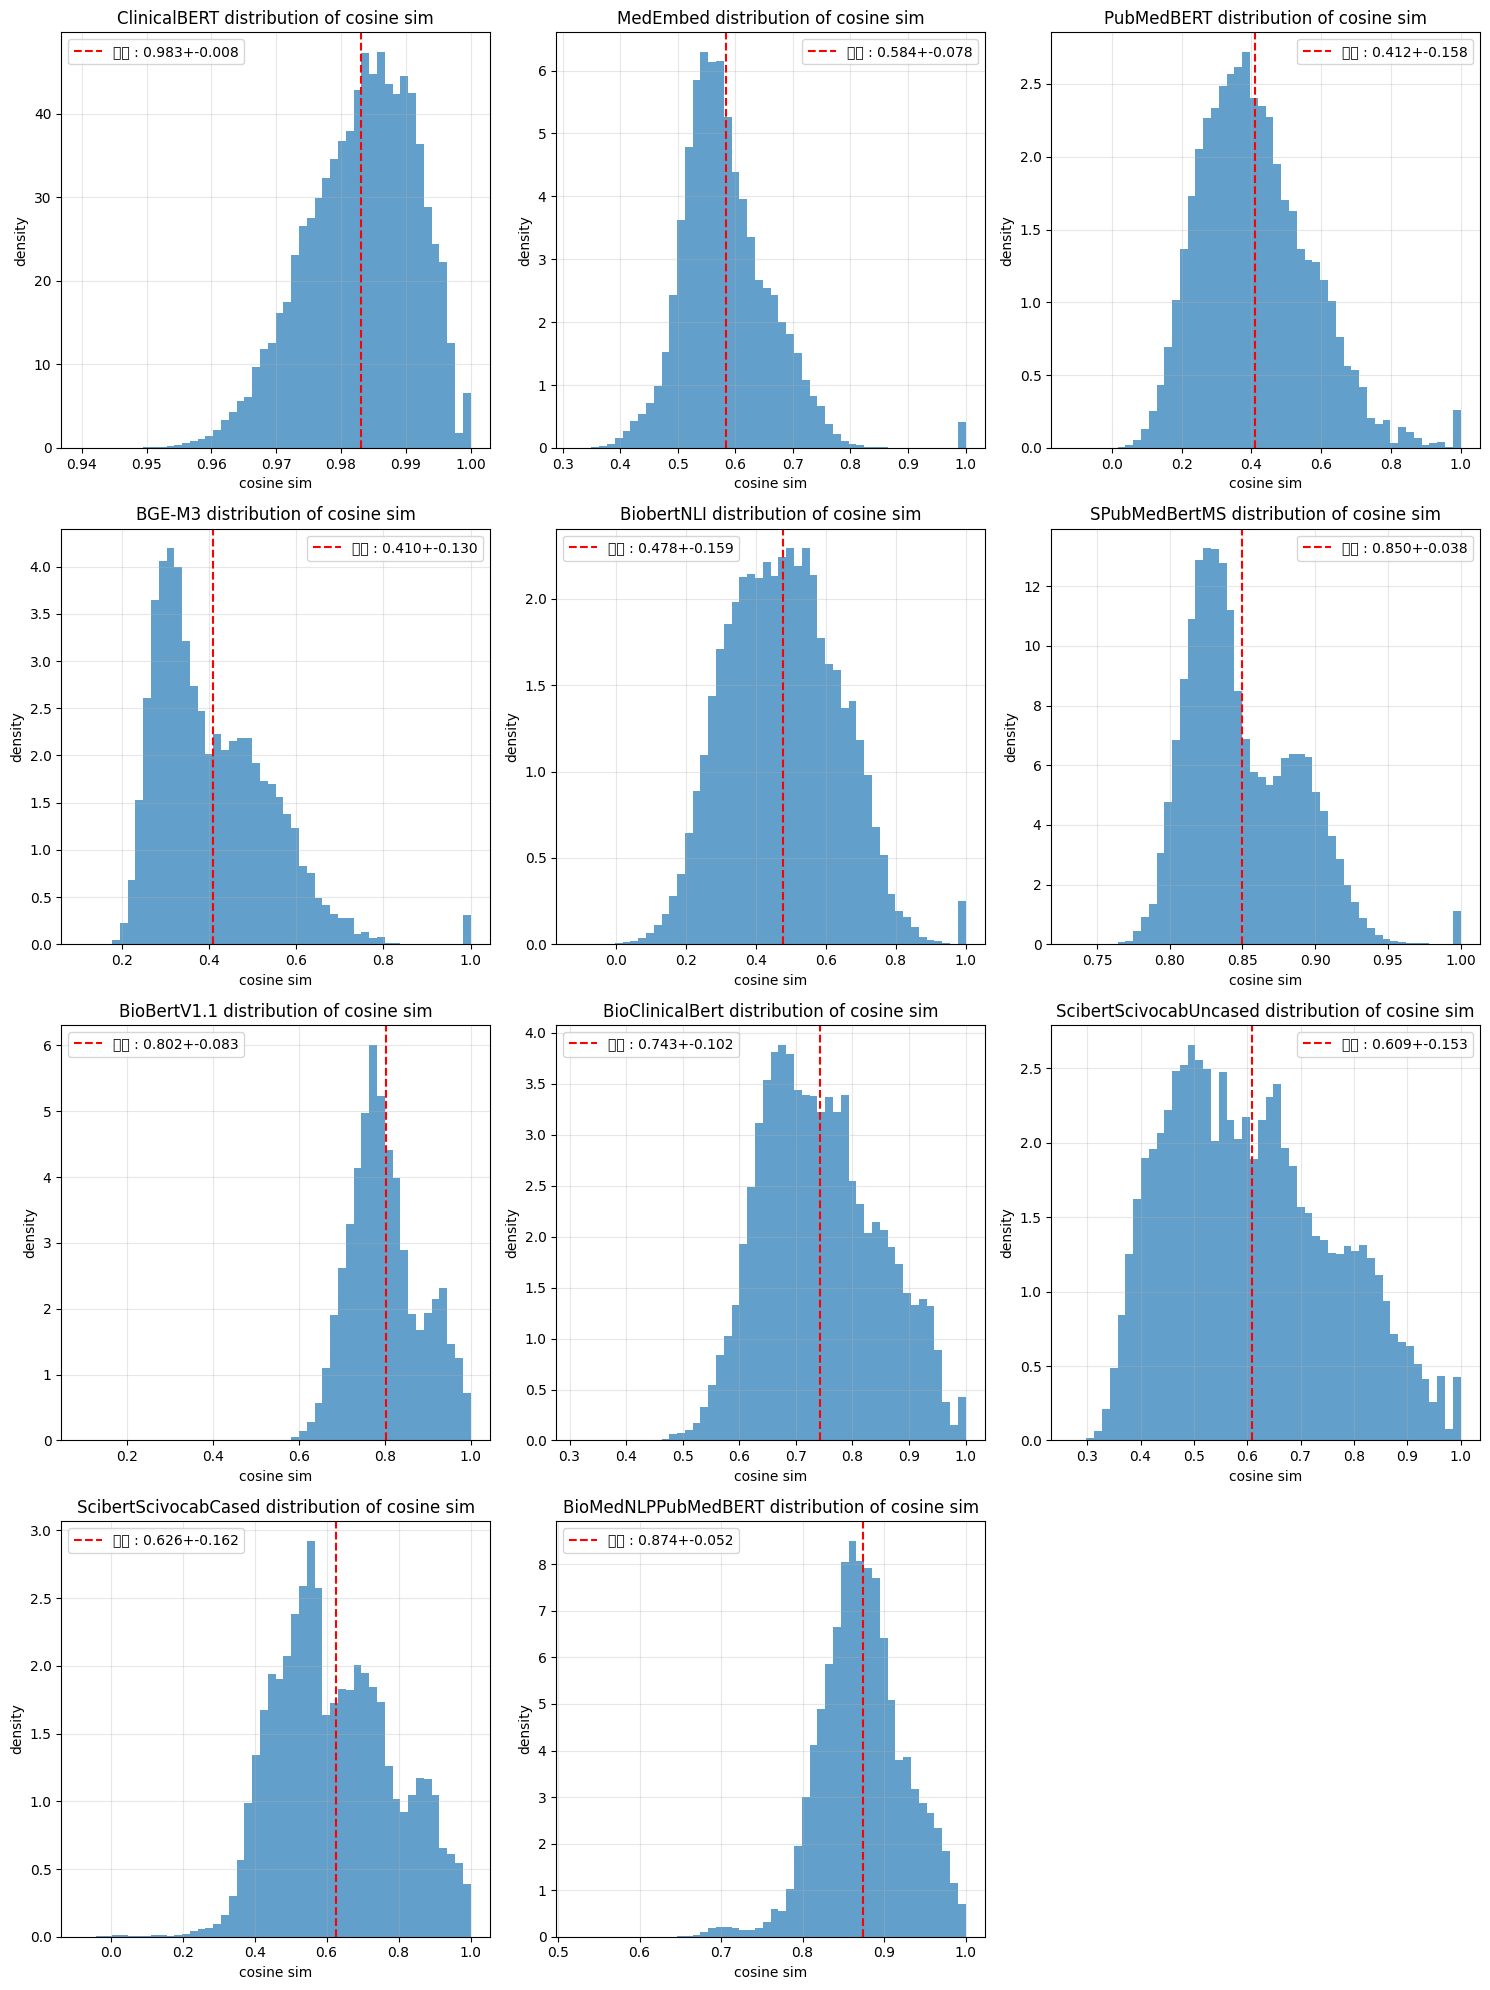

임베딩 시각화


/opt/conda/envs/sangwon/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/envs/sangwon/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/envs/sangwon/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/envs/sangwon/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/envs/sangwon/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/envs/sangwon/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 over

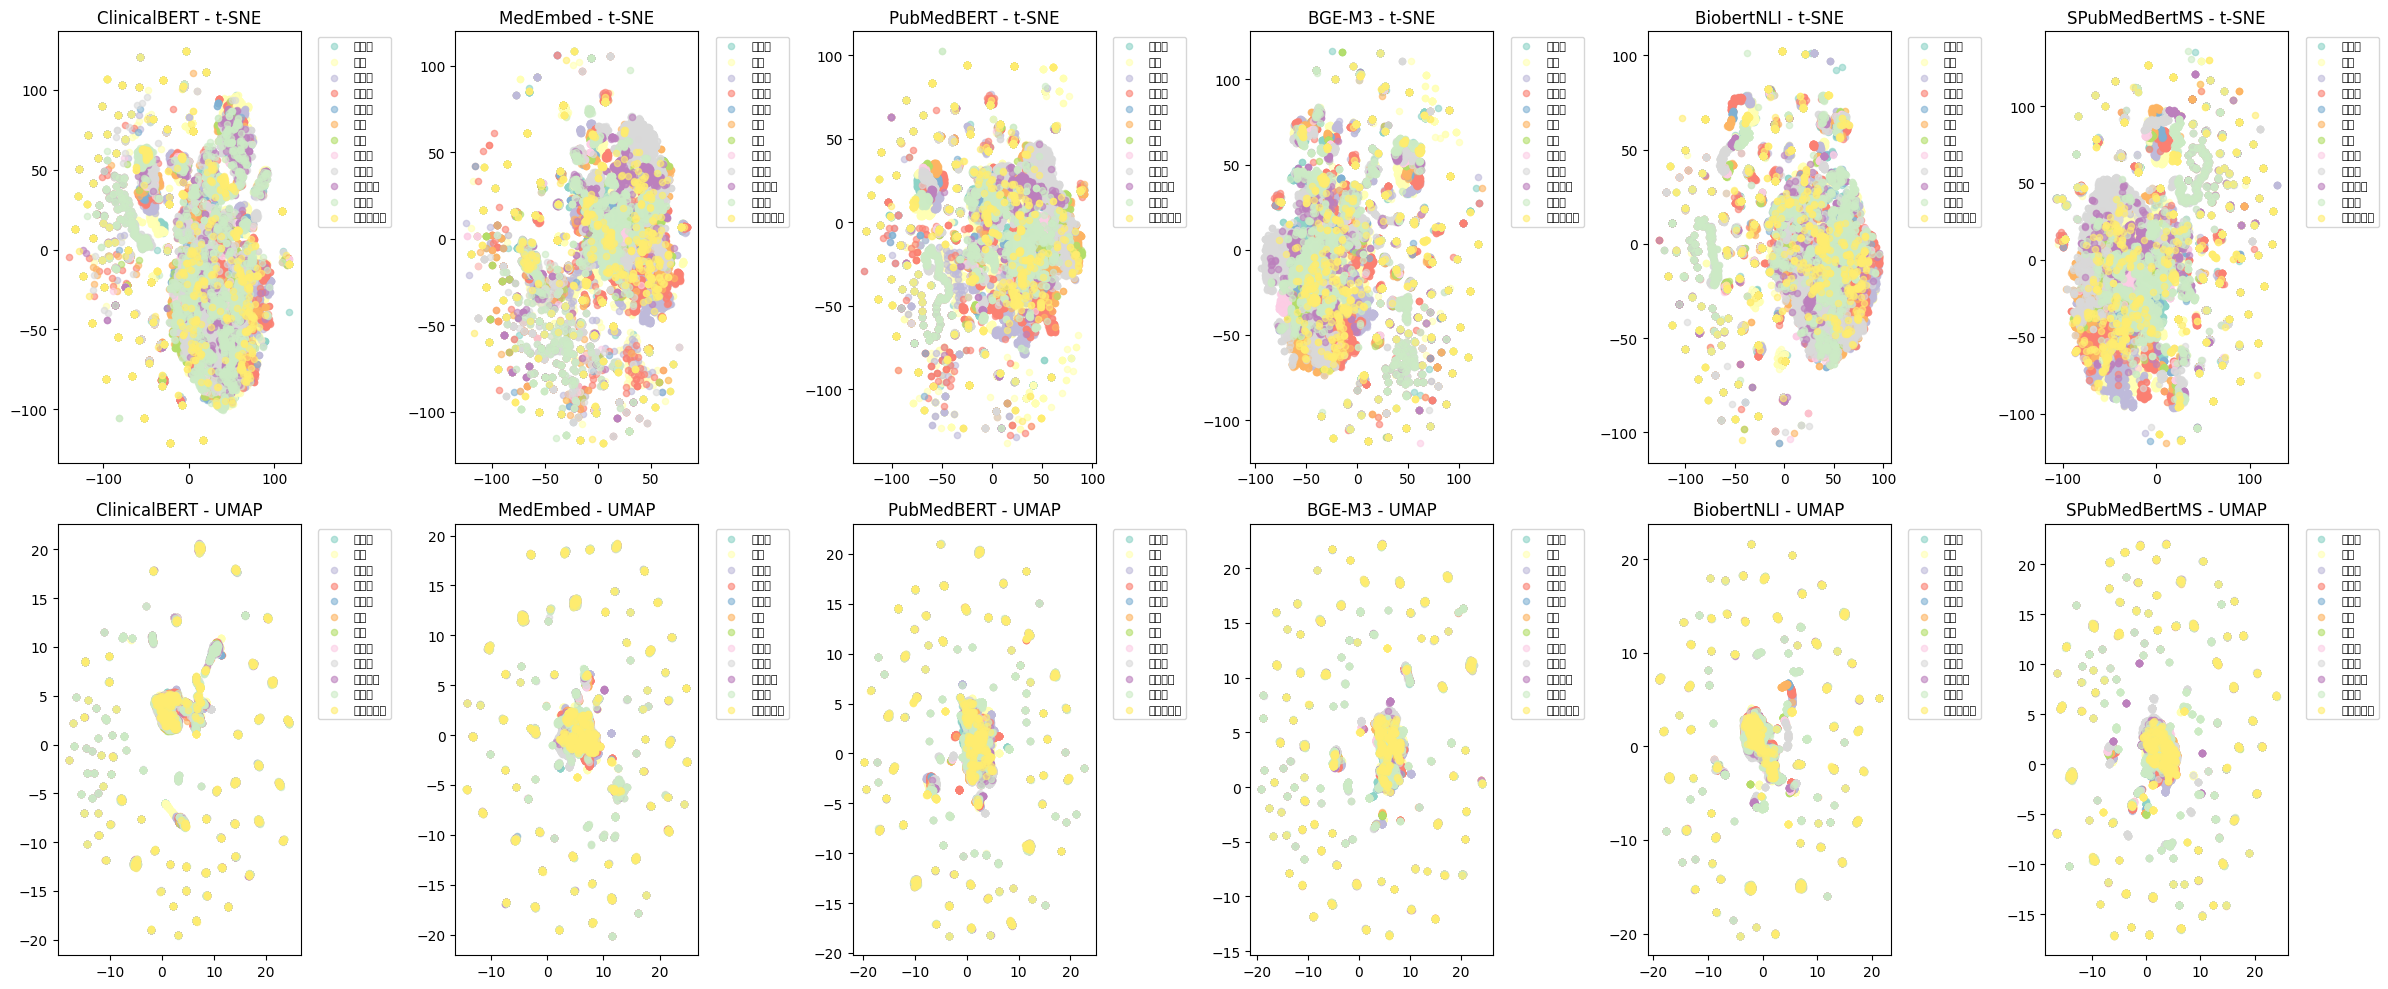

/opt/conda/envs/sangwon/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/envs/sangwon/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/envs/sangwon/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:392: UserWarning: Exited at iteration 2000 with accuracies 
[9.69518610e-12 1.35961671e-07 4.12486153e-07 3.40595930e-06]
not reaching the requested tolerance 1.1324882507324219e-06.
Use iteration 2001 instead with accuracy 
9.886042053865336e-07.

  _, diffusion_map = lobpcg(
/opt/conda/envs/sangwon/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:392: UserWarning: Exited postprocessing with accuracies 
[4.78495859e-12 1.35961288e-07 4.12486538e-07 3.40595926e-06]
not reaching the requested tolerance 1.1324882507324219e-06

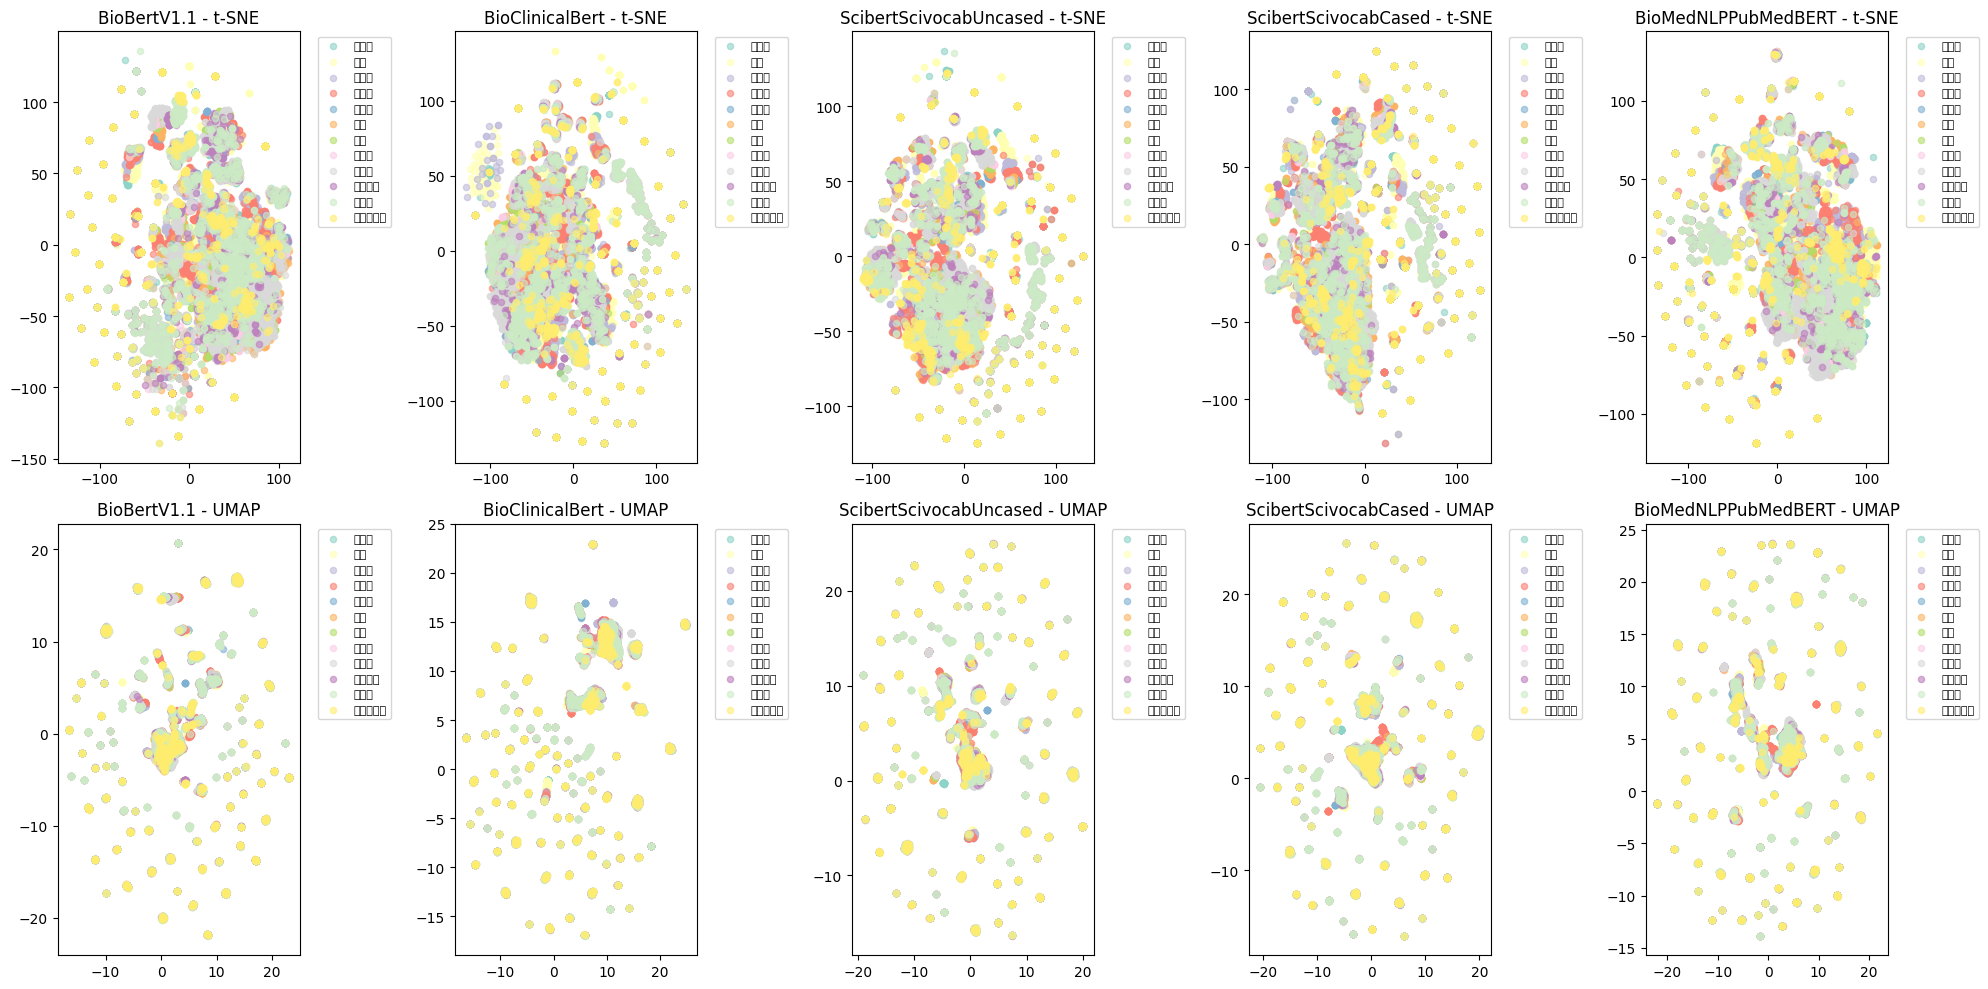

실루엣 스코어 계산


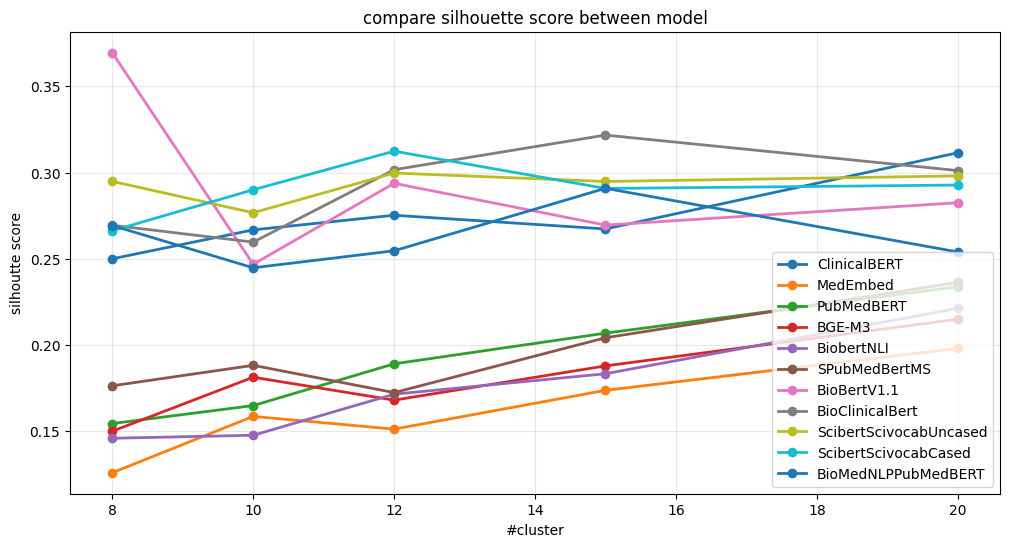


해부학 주제 수(12개)에서의 실루엣 스코어:
ClinicalBERT: 0.2753
MedEmbed    : 0.1513
PubMedBERT  : 0.1891
BGE-M3      : 0.1681
BiobertNLI  : 0.1715
SPubMedBertMS: 0.1724
BioBertV1.1 : 0.2938
BioClinicalBert: 0.3017
ScibertScivocabUncased: 0.2997
ScibertScivocabCased: 0.3124
BioMedNLPPubMedBERT: 0.2546


In [17]:
if __name__ == "__main__" :
    comparator = AnatomyEmbeddingComparator()
    results = comparator.main()